# **Bank Marketing Model Performance Analysis**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import shap
import warnings
warnings.filterwarnings("ignore")
plt.style.use('default')

# Data import

In [2]:
data = pd.read_csv("/kaggle/input/bank-marketing/bank-additional-full.csv", delimiter=';')
df = pd.DataFrame(data)
df.head(7)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
#duplicatedRows = df[df.duplicated()]
#print(duplicateRows)

In [5]:
df = df.drop_duplicates(keep = 'first')

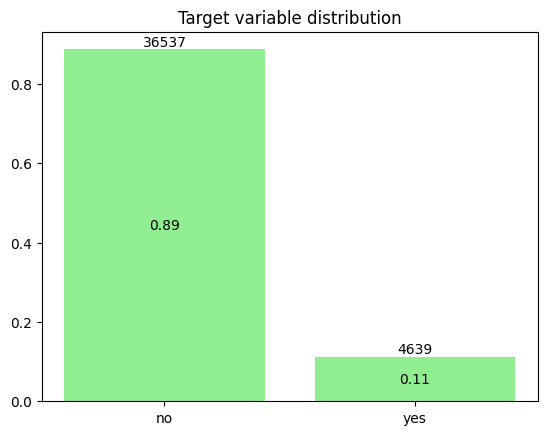

In [6]:
barplot = plt.bar(x = list(df['y'].unique()), height = list(df['y'].value_counts(normalize = True).values), fc = 'lightgreen' )
plt.bar_label(barplot, labels = list(df['y'].value_counts().values), label_type = "edge")
plt.bar_label(barplot, labels = list(round(df['y'].value_counts(normalize = True),2)), label_type = "center")
plt.title("Target variable distribution")
plt.show()


**Splitting data into numeric and categorical variables to examine distributions**

In [7]:
df_int = pd.DataFrame(df, columns = ['age', 'duration','campaign','pdays', 'previous','emp.var.rate','cons.price.idx', 'cons.conf.idx','euribor3m','nr.employed'])
df_cat = pd.DataFrame(df, columns = ['job', 'marital','education','default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'])

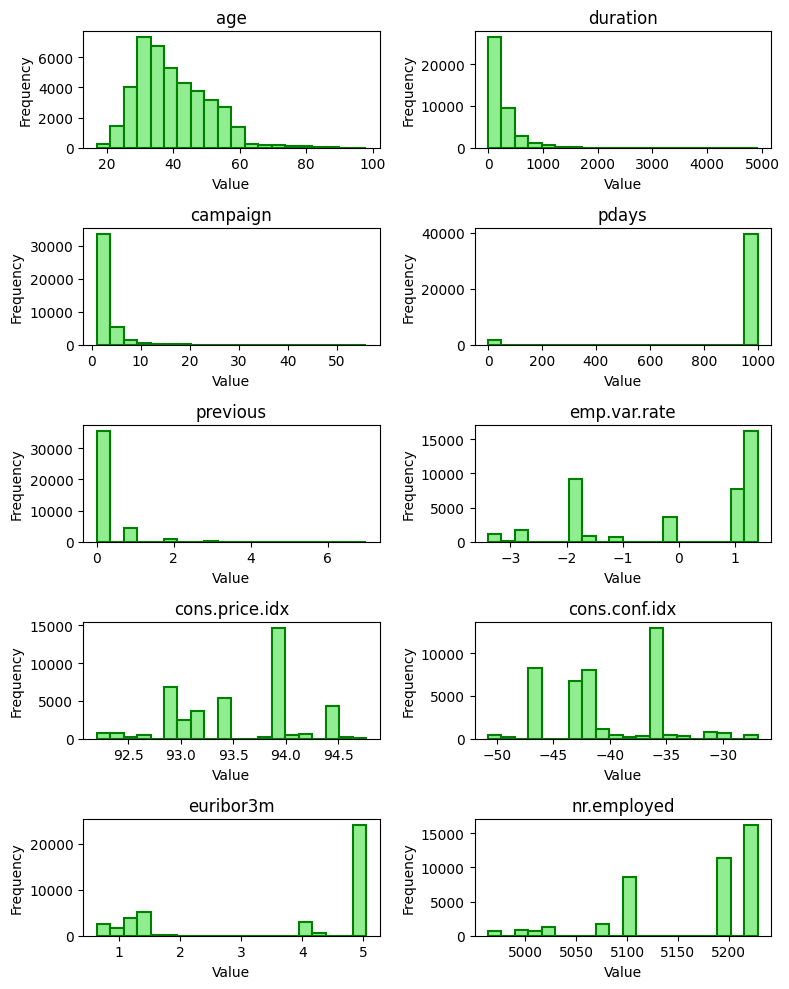

In [8]:
plt.figure(figsize=(8, 10))
for i, column in enumerate(df_int, 1):
    plt.subplot(5, 2, i)
    plt.hist(df_int[column], bins=20, color='lightgreen', edgecolor='green', linewidth=1.5)
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

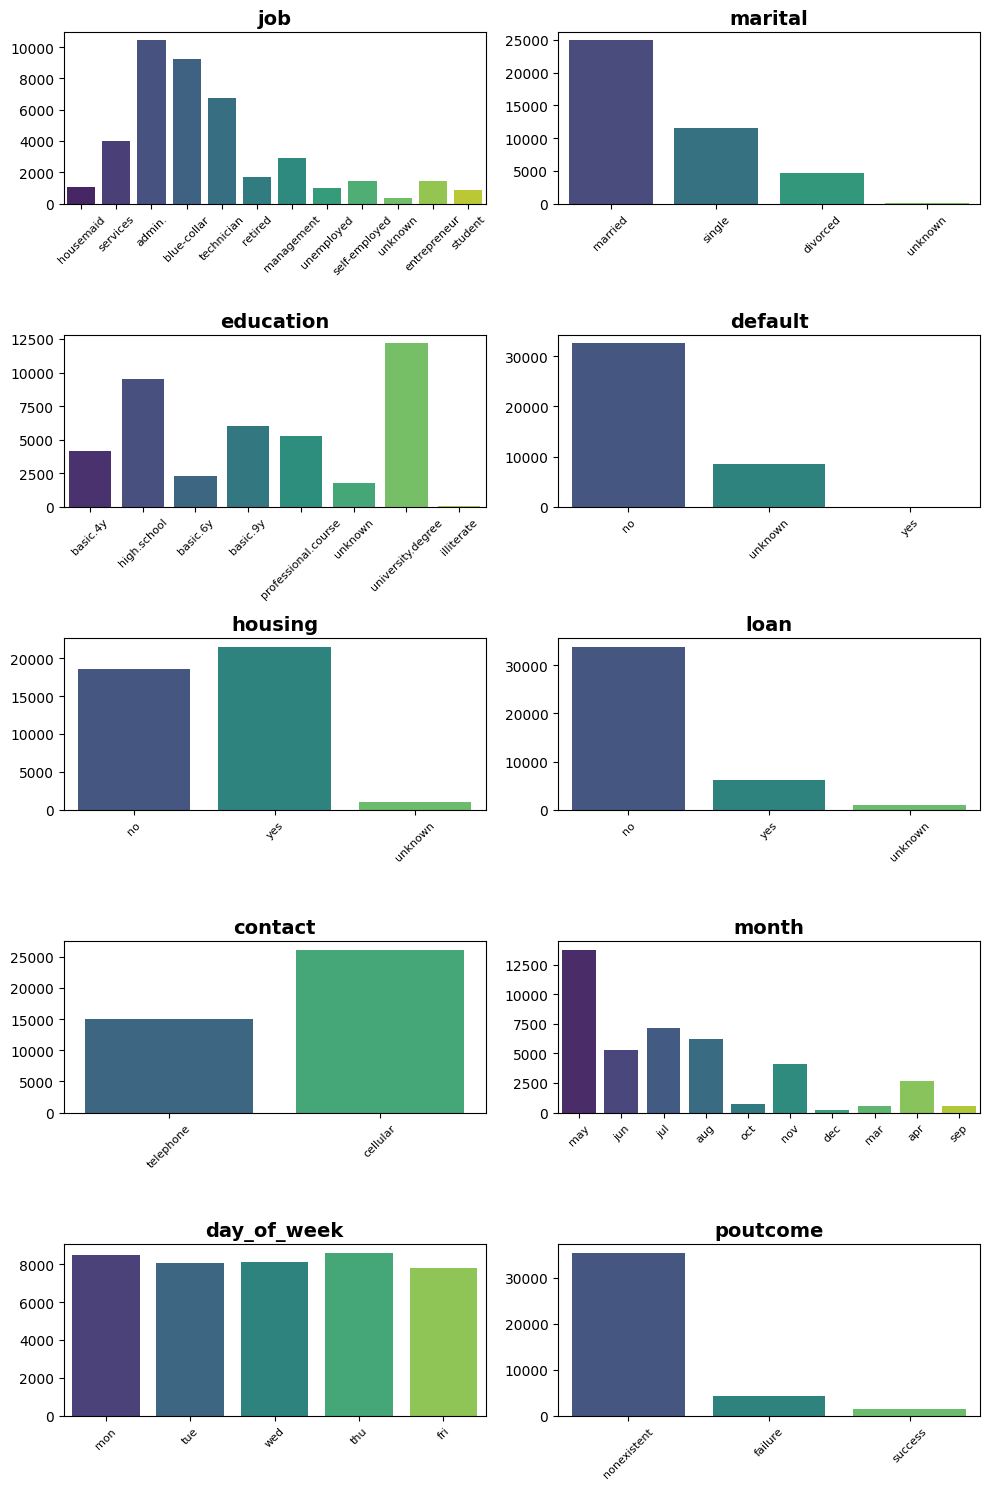

In [9]:
plt.figure(figsize=(10, 15))
for i, column in enumerate(df_cat, 1):
    plt.subplot(5, 2, i)
    sns.countplot(data=df_cat, x=column, palette='viridis')
    plt.title(column, fontsize=14, fontweight='bold') 
    plt.xlabel(None)
    plt.ylabel(None)
    plt.xticks(fontsize = 8, rotation=45)  

plt.tight_layout()
plt.show()

**Checking variables from the perspective of the dependent variable**

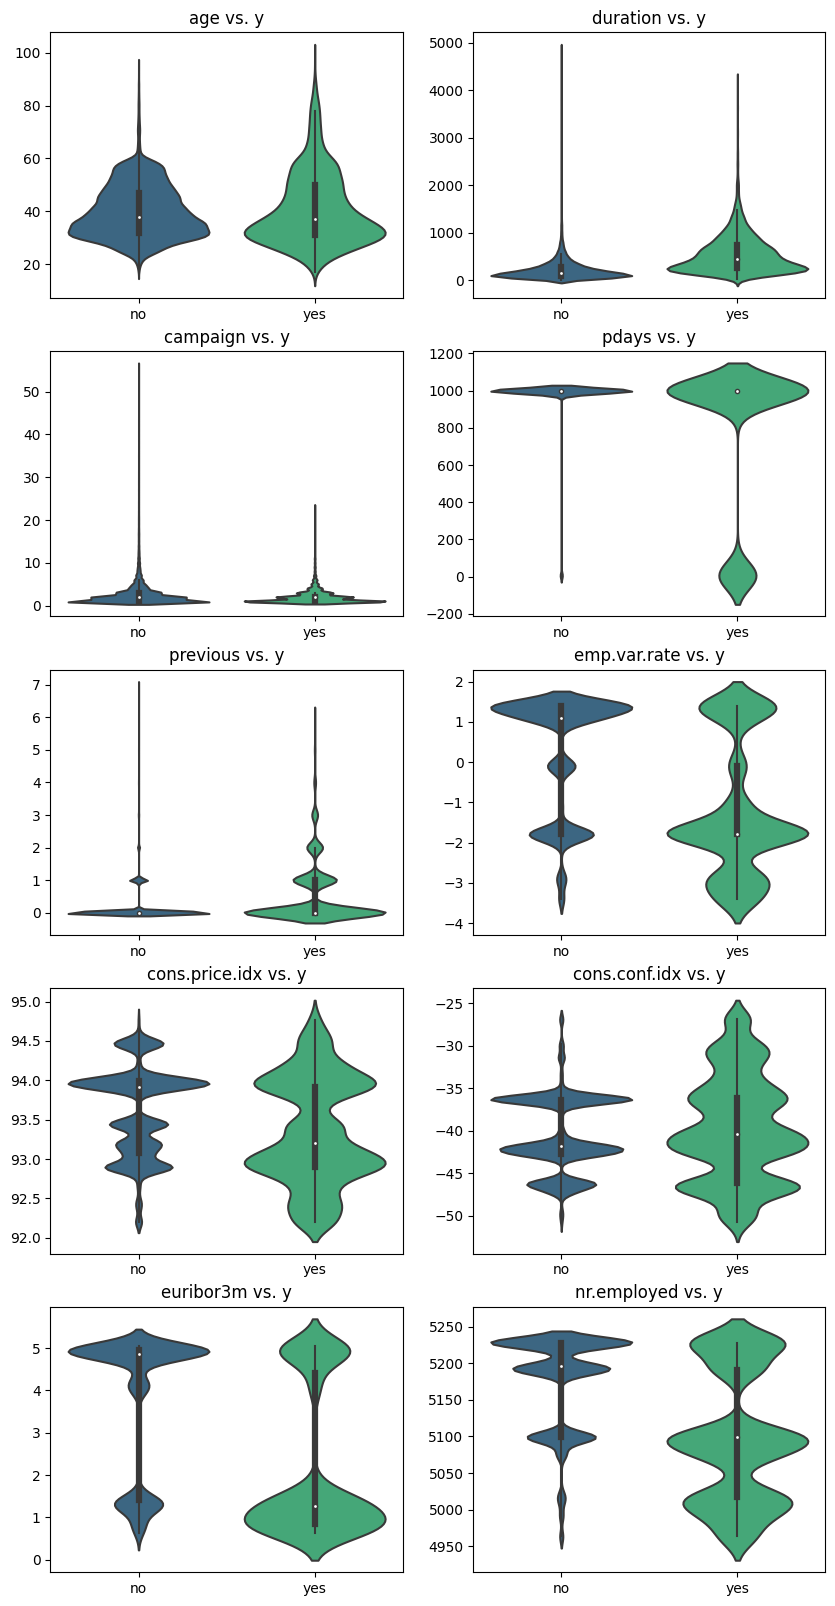

In [10]:
plt.figure(figsize=(10, 20))
for i, column in enumerate(df_int, 1):
    plt.subplot(5, 2, i)
    sns.violinplot(data= df, y=column, x ='y', palette='viridis',
                    scale="width")
    plt.title(f'{column} vs. y')
    plt.xlabel(None)
    plt.ylabel(None)
    
plt.show()

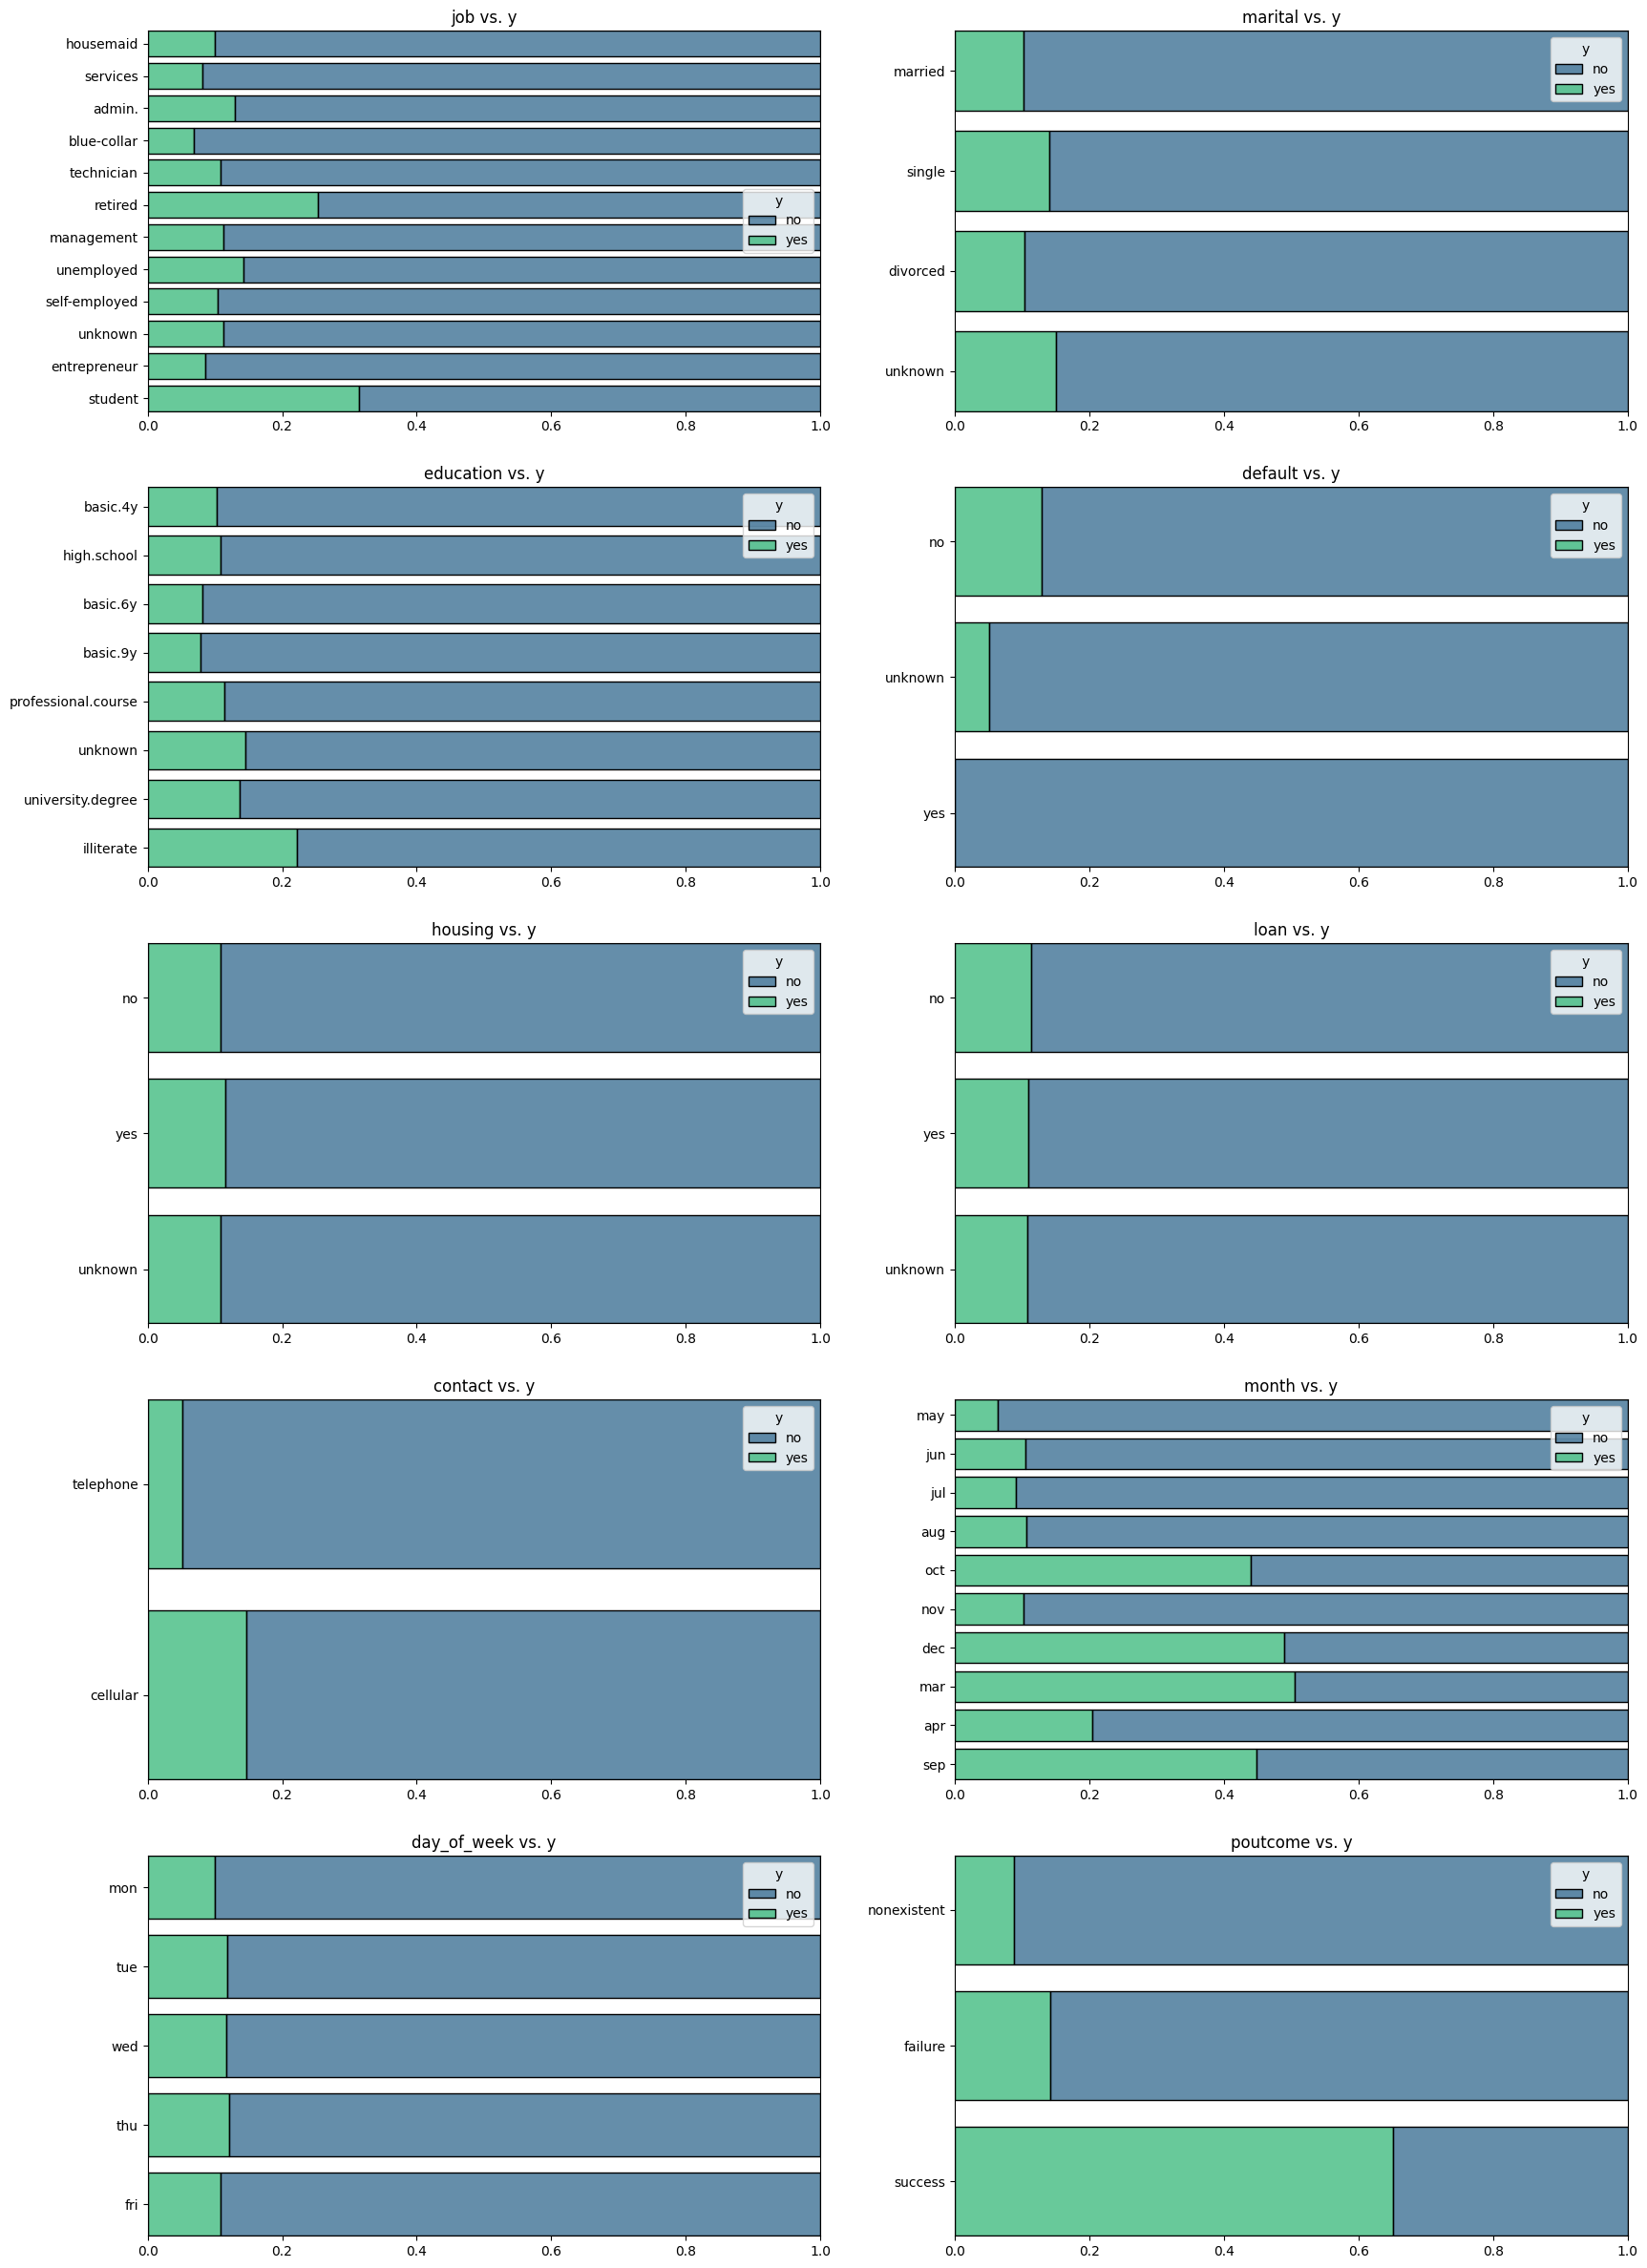

In [11]:
plt.figure(figsize=(20, 30))
for i, column in enumerate(df_cat, 1):
    plt.subplot(5, 2, i)
    sns.histplot(df, y=column, hue='y', palette='viridis',stat="probability", multiple="fill", shrink = .8)
    plt.title(f'{column} vs. y')
    plt.xlabel(None)
    plt.ylabel(None)
        
plt.show()

**Correlation Matrix of Numerical Variables**

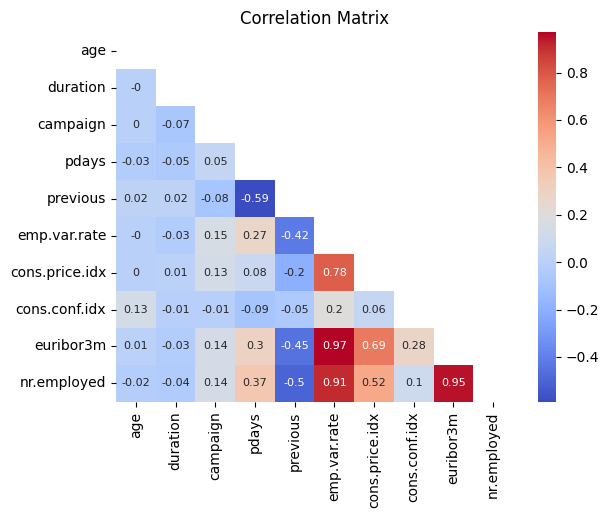

In [12]:
corr= round(df_int.corr(),2)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', annot_kws={"fontsize":8})
plt.title('Correlation Matrix')
plt.show()

Variable to remove:
- euribor3m, nr.employed (due to correlation)
- month, day_of_week (proper names)
- duration (this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.)



In [13]:
df_2 = df.drop( columns=['euribor3m', 'nr.employed','month','day_of_week','duration'])

# Data Processing

Categorical variables transformation

In [14]:
df_2['education'] = df_2['education'].replace(['basic.4y', 'basic.6y', 'basic.9y'], 'basic.edu')
df_2['education'] = df_2['education'].replace(['unknown', 'illiterate'], 'other.edu')
df_2['education'].value_counts()

education
basic.edu              12512
university.degree      12164
high.school             9512
professional.course     5240
other.edu               1748
Name: count, dtype: int64

In [15]:
df_2 = df_2[df_2['marital'] != 'unknown']
df_2['marital'].value_counts().sort_index()

marital
divorced     4611
married     24921
single      11564
Name: count, dtype: int64

In [16]:
df_2 = df_2[df_2['default'] != 'yes']
df_2['default'].value_counts().sort_index()

default
no         32508
unknown     8585
Name: count, dtype: int64

In [17]:
#df_2 = df_2[df_2['housing'] != 'unknown']
#df_2['housing'].value_counts().sort_index()

In [18]:
cat_age = [0, 25, 35,45,60,100]

df_2['age_cat'] = pd.cut(df_2['age'],cat_age)
df_2['age_cat'].value_counts().sort_index()


age_cat
(0, 25]       1663
(25, 35]     14805
(35, 45]     12826
(45, 60]     10892
(60, 100]      907
Name: count, dtype: int64

Numerical variable transformation.

My intention is to assign numbers according to category alphabetical order to know which number represents which category.

In [19]:
col_to_label = ['age_cat','job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y']
for c in col_to_label:
    for i, col in enumerate(np.sort(df_2[c].unique())):
        df_2[c] = df_2[c].replace(col,i) 

for c in col_to_label:
    print(df_2[c].value_counts().sort_index())    
    

age_cat
0     1663
1    14805
2    12826
3    10892
4      907
Name: count, dtype: int64
job
0     10405
1      9239
2      1453
3      1057
4      2921
5      1713
6      1416
7      3961
8       874
9      6725
10     1008
11      321
Name: count, dtype: int64
marital
0     4611
1    24918
2    11564
Name: count, dtype: int64
education
0    12492
1     9497
2     1739
3     5232
4    12133
Name: count, dtype: int64
default
0    32508
1     8585
Name: count, dtype: int64
housing
0    18569
1      989
2    21535
Name: count, dtype: int64
loan
0    33868
1      989
2     6236
Name: count, dtype: int64
contact
0    26079
1    15014
Name: count, dtype: int64
poutcome
0     4238
1    35487
2     1368
Name: count, dtype: int64
y
0    36466
1     4627
Name: count, dtype: int64


Normalization for numerical

In [20]:
col_to_norm = ['campaign', 'pdays', 'previous','emp.var.rate', 'cons.price.idx', 'cons.conf.idx']

for c in col_to_norm:
    x_norm = (df_2[c] - df_2[c].mean())/df_2[c].std()
    df_2[c] = df_2[c].map(dict(zip(list(df_2[c]), x_norm)))

print(df_2)

       age  job  marital  education  default  housing  loan  contact  \
0       56    3        1          0        0        0     0        1   
1       57    7        1          1        1        0     0        1   
2       37    7        1          1        0        2     0        1   
3       40    0        1          0        0        0     0        1   
4       56    7        1          1        0        0     2        1   
...    ...  ...      ...        ...      ...      ...   ...      ...   
41183   73    5        1          3        0        2     0        0   
41184   46    1        1          3        0        0     0        0   
41185   56    5        1          4        0        2     0        0   
41186   44    9        1          3        0        0     0        0   
41187   74    5        1          3        0        2     0        0   

       campaign    pdays  previous  poutcome  emp.var.rate  cons.price.idx  \
0     -0.566030  0.19531 -0.349212         1      0.64782

In [21]:
df_2 = df_2.drop(columns=['age'])

y = df_2['y'].values
X = df_2.drop(['y'], axis=1).values          

# Models preselection

In [22]:
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier(), "Random Forrest": RandomForestClassifier(), 
          "GBoost":GradientBoostingClassifier() }
results = []
for model in models.values():
    kf = KFold(n_splits=5, random_state=10, shuffle=True)
    cv_results = cross_val_score(model, X, y, scoring = "roc_auc", cv=kf) 
    results.append(cv_results)
   
print(results)


[array([0.77406081, 0.78843604, 0.77284362, 0.79912655, 0.77755612]), array([0.70348652, 0.71538053, 0.71318634, 0.72842455, 0.71296487]), array([0.6050862 , 0.62478828, 0.62364286, 0.62426119, 0.6176613 ]), array([0.73533228, 0.75136207, 0.73929242, 0.76282431, 0.75087986]), array([0.78625609, 0.80240848, 0.78827567, 0.81629392, 0.79488245])]


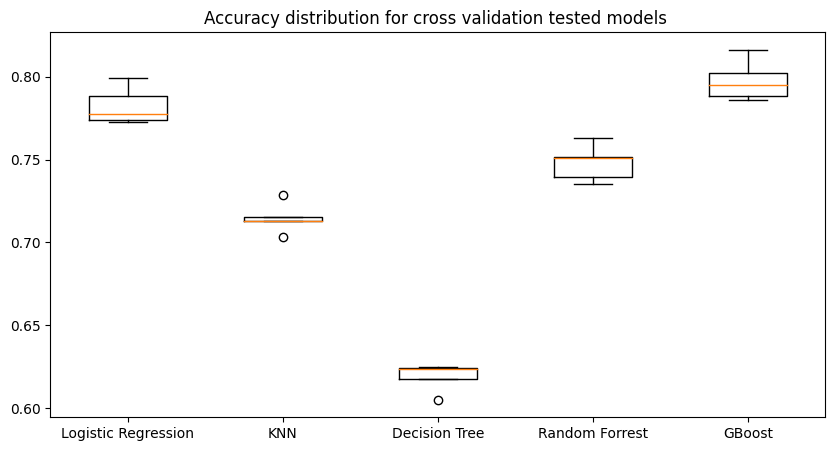

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot (results)
ax.set_xticklabels(models.keys())
ax.set_title("Accuracy distribution for cross validation tested models ")
plt.show()

**Split data into train, test sets.**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10, stratify=y)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (32874, 15) (32874,)
Testing set shape: (8219, 15) (8219,)


# Models, training, prediction and evaluation
**Detailed metrics for selected models
(default parameters)**

**Logistic Regression and Gradient Boosting compare**

In [25]:
Model_names, Accuracy, AUC, Recall, Precision = [], [], [], [], []

In [26]:
Model_names.append("LogisticRegression")

model_lg = LogisticRegression(random_state=10)

model_lg.fit(X_train, y_train)
y_pred_lg = model_lg.predict(X_test)
y_prob_lg = model_lg.predict_proba(X_test)[:,1]
#acc_lg = model_lg.score(X_test, y_test)
acc_lg = accuracy_score(y_test, y_pred_lg)
precision_lg = precision_score(y_test, y_pred_lg, pos_label=1)
recall_lg = recall_score(y_test, y_pred_lg, pos_label=1)
ROC_AUC_lg = roc_auc_score(y_test, y_prob_lg)

Accuracy.append(round(acc_lg, 4))
AUC.append(round(ROC_AUC_lg, 4))
Recall.append(round(recall_lg, 4))
Precision.append(round(precision_lg, 4))

#print(model_lg.get_params())

In [27]:
Model_names.append("GBoost")

model_gb = GradientBoostingClassifier(random_state = 10)

model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
y_prob_gb = model_gb.predict_proba(X_test)[:,1]

acc_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, pos_label=1)
recall_gb = recall_score(y_test, y_pred_gb, pos_label=1)
ROC_AUC_gb = roc_auc_score(y_test, y_prob_gb)

Accuracy.append(round(acc_gb, 4))
AUC.append(round(ROC_AUC_gb, 4))
Recall.append(round(recall_gb, 4))
Precision.append(round(precision_gb, 4))


In [28]:
Model_results = pd.DataFrame ({'Model':Model_names, 'Accuracy':Accuracy, 'AUC':AUC, 'Recall':Recall, 'Precision':Precision})
print(Model_results) 

                Model  Accuracy     AUC  Recall  Precision
0  LogisticRegression    0.8973  0.7854  0.2054     0.6355
1              GBoost    0.8995  0.7952  0.2162     0.6645


**The results are at a similar level, however, the Recall is unsatisfactory and needs to be improved**

In [29]:
for p in ["balanced", {0:0.2, 1:0.8}]:
    model_lg = LogisticRegression(random_state=10,class_weight = p )

    model_lg.fit(X_train, y_train)
    y_pred_lg = model_lg.predict(X_test)
    y_prob_lg = model_lg.predict_proba(X_test)[:,1]

    acc_lg = accuracy_score(y_test, y_pred_lg)
    precision_lg = precision_score(y_test, y_pred_lg, pos_label=1)
    recall_lg = recall_score(y_test, y_pred_lg, pos_label=1)
    ROC_AUC_lg = roc_auc_score(y_test, y_prob_lg)

    print ("Result for class weihgt: ", p)
    print("Accuracy:", acc_lg)
    print("Precision:", precision_lg)
    print("Recall:", recall_lg)
    print("AUC:", ROC_AUC_lg)
    print()

Result for class weihgt:  balanced
Accuracy: 0.7717483878817374
Precision: 0.28277752398355416
Recall: 0.6691891891891892
AUC: 0.7852565233179436

Result for class weihgt:  {0: 0.2, 1: 0.8}
Accuracy: 0.8745589487772235
Precision: 0.44721115537848605
Recall: 0.4854054054054054
AUC: 0.7852842395452759



# Target Model

In [30]:
model_best = LogisticRegression(random_state=10,class_weight = {0: 0.2, 1: 0.8} )

model_best.fit(X_train, y_train)
y_pred_best = model_best.predict(X_test)
y_prob_best = model_best.predict_proba(X_test)[:,1]

acc_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, pos_label=1)
recall_best = recall_score(y_test, y_pred_best, pos_label=1)
ROC_AUC_best = roc_auc_score(y_test, y_prob_best)
CM = confusion_matrix(y_test, y_pred_best)

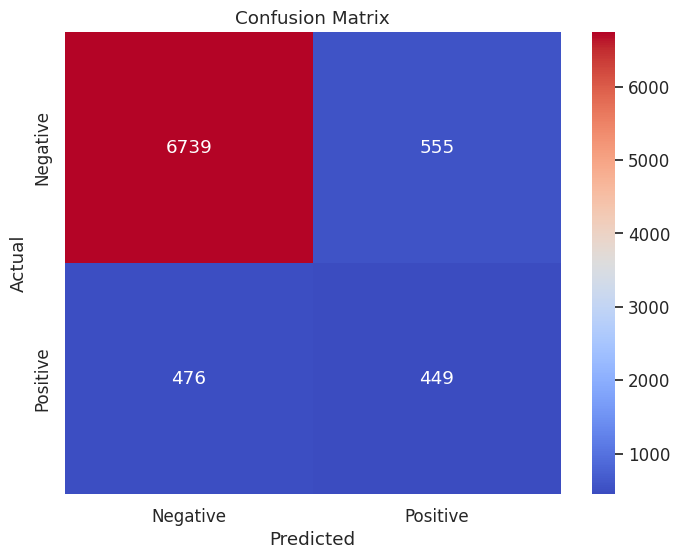

In [31]:
plt.figure(figsize=(8,6), dpi = 100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(CM, annot=True, fmt='d',cmap='coolwarm')
ax.set_xlabel("Predicted")
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual")
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_title ("Confusion Matrix")
plt.show()

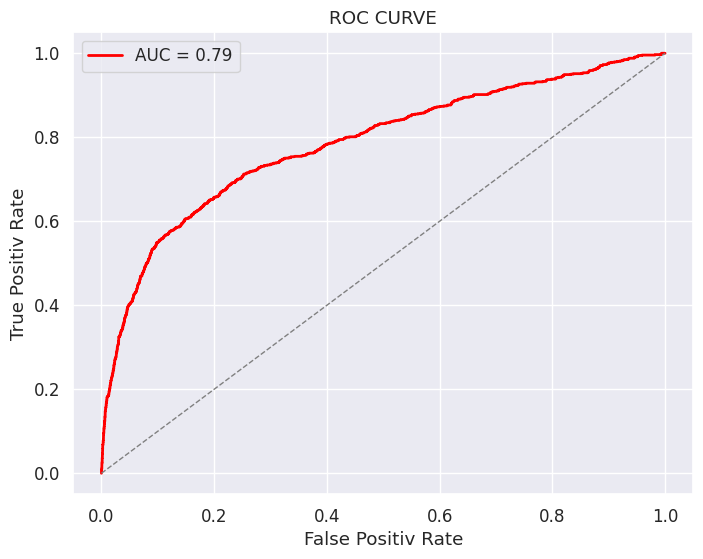

In [32]:
fpr, tpr, _ = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel("False Positiv Rate")
plt.ylabel("True Positiv Rate")
plt.title("ROC CURVE")
plt.legend(loc='upper left')
plt.show()
plt.style.use('default')

# Feature Importance 

In [33]:
coefficients = list(model_best.coef_[0])
odds_rate = list(np.exp(coefficients))
print(coefficients)
print(odds_rate)
feature_names = list(df_2.drop(['y'], axis=1).columns)
feature_df = pd.DataFrame({'Feature':feature_names, 'Coeff':coefficients, 'Odds':odds_rate })
print(feature_df.sort_values(by = 'Coeff', ascending=False))

[0.0016702644990797817, 0.0914293364858586, 0.04998899594039002, -0.22573232968405252, -0.023640853271668993, -0.028194633525802475, -0.9131215752745336, -0.10820346956457506, -0.17928889293821207, -0.031908328738530944, 0.5052505670536142, -1.177928015531891, 0.6953163918513057, 0.22464645506526865, 0.012146173276437312]
[1.0016716601677653, 1.0957393451640691, 1.0512595281898618, 0.7979316557017473, 0.9766364025477997, 0.9721991258418821, 0.4012696734742144, 0.8974449751138085, 0.835864389194078, 0.968595370368923, 1.6574007584609025, 0.30791607542287713, 2.004343131464585, 1.251880042096109, 1.012220237601345]
           Feature     Coeff      Odds
12  cons.price.idx  0.695316  2.004343
10        poutcome  0.505251  1.657401
13   cons.conf.idx  0.224646  1.251880
1          marital  0.091429  1.095739
2        education  0.049989  1.051260
14         age_cat  0.012146  1.012220
0              job  0.001670  1.001672
4          housing -0.023641  0.976636
5             loan -0.028195

(8219, 15)
<class 'numpy.ndarray'>
(8219, 15)
<class 'numpy.ndarray'>


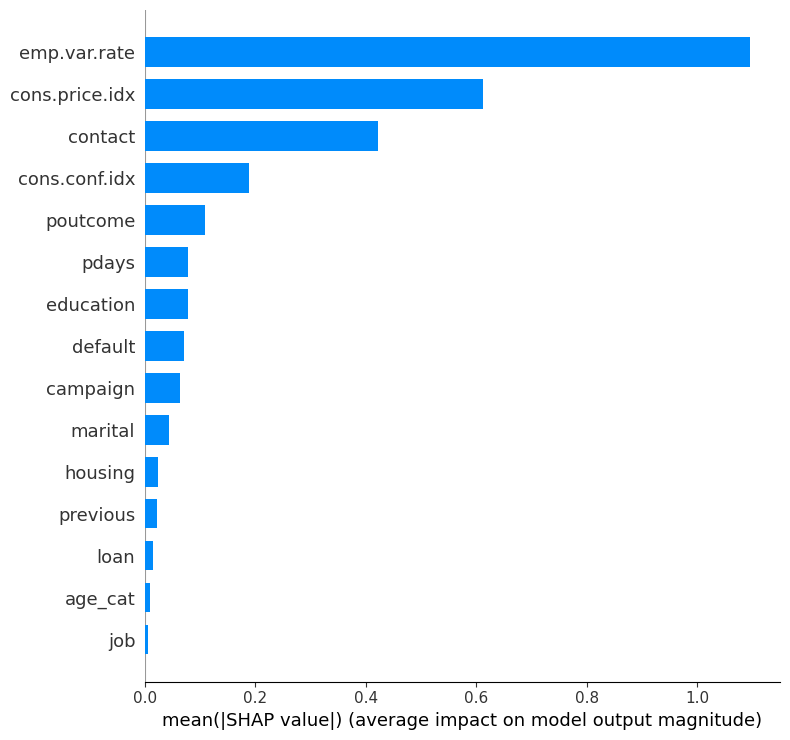

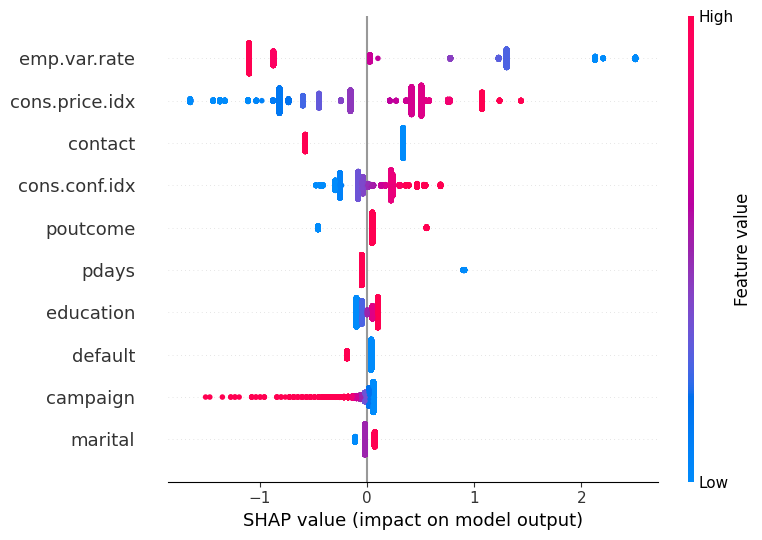

In [34]:
masker = shap.maskers.Independent(data = X_test)
explainer = shap.LinearExplainer(model_best,masker=masker )
shap_values = explainer.shap_values(X_test)
print(np.shape(shap_values))
print(type(shap_values))
print(np.shape(X_test))
print(type(X_test))
shap.summary_plot(shap_values, X_test, plot_type= "bar", feature_names=feature_names, max_display=len(feature_names))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, max_display=10)